In [3]:
pip install networkx-query

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Bibliotecas

In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx_query import search_nodes
from functools import reduce

Geração dos dados sintéticos

# Erdos-Renyi

In [24]:
N = 400 #número de vértices
d = 6 # grau médio
p_edges = 0.036
T = 7 # tempo de pandemia

2914


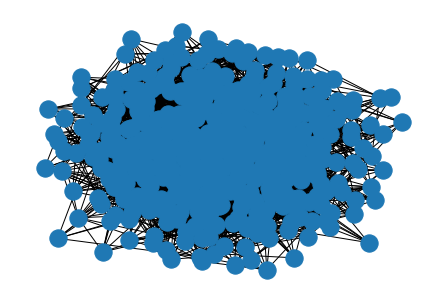

In [25]:
Gnx = nx.erdos_renyi_graph(N, p_edges)
print(nx.number_of_edges(Gnx))
nx.draw(Gnx)
Gnx_c = Gnx.copy()

In [26]:
G = nx.to_numpy_array(Gnx_c)
aux = np.random.rand(*G.shape)
W = (aux < 0.85)*(np.random.random(size=G.shape)/10) + (aux > 0.85)*(np.random.random(size=G.shape)/20 + 0.3 )
G = G*W

In [27]:
Gnx.nodes[0]['I'] = 0
Gnx_c.nodes[0]['I'] = 0

In [28]:
Gnx.degree[0]

20

Espalhamento da doença:

In [29]:
def SIR_simulation(Gnx, G):
  I_0 = [0]
  for day in range(1,T+1):
    I_1 = []
    if I_0:
      for node in I_0:
        for neighbor in Gnx.neighbors(node):
          if (Gnx.nodes.data('I')[neighbor] is None):
            U = np.random.random()
            if G[node, neighbor] > U:
              I_1.append(neighbor)
              Gnx.nodes[neighbor]['I'] = day
    I_0 = I_1
    print(I_0)
  return Gnx

In [30]:
Gnx = Gnx_c.copy()
G_SIR = SIR_simulation(Gnx, G)

[132, 139]
[153]
[45, 73, 77, 315]
[10, 349, 51, 316, 362]
[161, 25, 276, 31, 37, 122, 90, 99, 310, 397, 195, 332, 358]
[225, 94, 220, 248, 273, 136, 102, 300, 190, 137, 160, 394, 196, 211, 308, 378]
[146, 371, 9, 120, 111, 143, 30, 48, 251, 11, 114, 5, 167, 118, 279, 285, 286, 100, 339, 323, 374]


In [31]:
S = 0
for t in range(T+1):
  s = 0
  for node in G_SIR.nodes:
    if G_SIR.nodes.data('I')[node] == t:
      s += 1
  S += s
  print(t, ' :', s)
print(S)

0  : 1
1  : 2
2  : 1
3  : 4
4  : 5
5  : 13
6  : 16
7  : 21
63


Algoritmo

In [62]:
C = []
for v in G_SIR.nodes:
  if type(G_SIR.nodes.data('I')[v]) == int:
    #U = np.random.random()
    #if U < 0.1:
    C += [[v, G_SIR.nodes.data('I')[v]]]
C_ = pd.DataFrame(C)
C_ = C_.rename(columns={0: 'node', 1: 'time'})
C = C_.sample(frac = 0.5)
#C = C_[C_['time'] == 1]
#for t in range(2,T-1):
#  C = pd.concat([C, C_[C_['time'] == t].sample(frac=0.99)])
#C

In [63]:
len(C)

32

In [64]:
from decimal import *
getcontext().prec = 100

In [65]:
def estimator_P_C(C, num = 50):
  Q = 0
  n = 0
  k = 0
  Tree = Gnx_c.copy()
  while n < num:
    L = Decimal(1)
    for t in range(1,T+1):
      Inf = set()
      infec = [Decimal(1) for i in range(N)]
      n_infec = [Decimal(1) for i in range(N)]
      for v in search_nodes(Tree, {"==": [("I",), t-1]}):
        for u in Tree.neighbors(v):
          if u in C.node.values:
            if C[C['node'] == u].time.values[0] == t:
              infec[u] *= Decimal(str(1-G[v,u]))
              Tree.nodes[u]['I'] = t
              Inf = Inf.union({u})
            else:
              n_infec[u] *= Decimal(str(1-G[v,u]))
          else:
            U = np.random.random()
            if (Tree.nodes.data('I')[u] is None):
              if U <  G[v,u]:
                Tree.nodes[u]['I'] = t
      L *= reduce(lambda x,y:x*y, n_infec)
      for i in infec:
        if i != Decimal(1):
          L *= (Decimal(1)-i)
      fail = Inf != set(C[C['time'] == t].node)
      if fail:
        break
    k += 1
    if k > 300:
      print(k)
      return
    if not fail:
      n += 1
      Q += L
  Q = Q / Decimal(num)
  print(k)
  return Q

In [66]:
p1 = estimator_P_C(C, num = 200)
p1

301


In [67]:
d = pd.DataFrame({'node': [16], 'time': [2]})
p2 = estimator_P_C(pd.concat([C, d]),num = 200)
p2

204


Decimal('2.410754590542098976168451205926335347876641800861476155109617989577849705938606493519671092507268364E-35')

In [68]:
p2/p1

TypeError: ignored

# Barabási-Albert

In [128]:
N = 400 #número de vértices
d = 6 # grau médio
M = round(0.018*N)
T = 7 # tempo de pandemia

2751


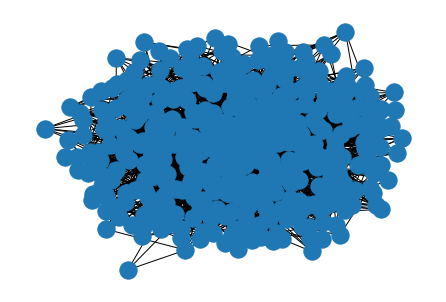

In [129]:
Gnx = nx.barabasi_albert_graph(N, M)
print(nx.number_of_edges(Gnx))
nx.draw(Gnx)
Gnx_c = Gnx.copy()

In [130]:
G = nx.to_numpy_array(Gnx_c)
aux = np.random.rand(*G.shape)
W = (aux < 0.85)*(np.random.random(size=G.shape)/10) + (aux > 0.85)*(np.random.random(size=G.shape)/20 + 0.3 )
G = G*W

In [131]:
Gnx.nodes[0]['I'] = 0
Gnx_c.nodes[0]['I'] = 0

In [132]:
Gnx.degree[0]

110

Espalhamento da doença:

In [133]:
def SIR_simulation(Gnx, G):
  I_0 = [0]
  for day in range(1,T+1):
    I_1 = []
    if I_0:
      for node in I_0:
        for neighbor in Gnx.neighbors(node):
          if (Gnx.nodes.data('I')[neighbor] is None):
            U = np.random.random()
            if G[node, neighbor] > U:
              I_1.append(neighbor)
              Gnx.nodes[neighbor]['I'] = day
    I_0 = I_1
    print(I_0)
  return Gnx

In [134]:
Gnx = Gnx_c.copy()
G_SIR = SIR_simulation(Gnx, G)

[32, 53, 55, 81, 154, 259, 299, 365, 368, 376]
[189, 33, 397, 9, 156, 375, 50, 149, 1, 14, 22]
[69, 256, 114, 3, 17, 25, 60, 76, 153, 173, 263, 352, 11, 281, 35, 160, 71, 254, 273, 279, 325, 59, 306]
[201, 56, 90, 145, 200, 15, 106, 178, 7, 253, 302, 34, 341, 290, 43, 62, 47, 350, 199, 245, 5]
[19, 40, 110, 37, 164, 23, 44, 52, 75, 80, 104, 119, 68, 16, 18, 157, 367, 87, 67, 85, 388, 58, 10, 322, 228, 12, 38, 91, 128]
[45, 194, 260, 284, 63, 235, 239, 138, 269, 172, 57, 377, 111, 158, 107, 234, 337, 369, 147, 96, 237, 8]
[72, 363, 13, 346, 134, 339, 86, 100, 188, 295, 49, 230, 46, 381, 31, 98, 99, 136, 168, 216, 242, 297, 300]


In [135]:
S = 0
for t in range(T+1):
  s = 0
  for node in G_SIR.nodes:
    if G_SIR.nodes.data('I')[node] == t:
      s += 1
  S += s
  print(t, ' :', s)
print(S)

0  : 1
1  : 10
2  : 11
3  : 23
4  : 21
5  : 29
6  : 22
7  : 23
140


Algoritmo

In [142]:
C = []
for v in G_SIR.nodes:
  if type(G_SIR.nodes.data('I')[v]) == int:
    #U = np.random.random()
    #if U < 0.1:
    C += [[v, G_SIR.nodes.data('I')[v]]]
C_ = pd.DataFrame(C)
C_ = C_.rename(columns={0: 'node', 1: 'time'})
C = C_.sample(frac = 0.90)
#C = C_[C_['time'] == 1]
#for t in range(2,T-1):
#  C = pd.concat([C, C_[C_['time'] == t].sample(frac=0.99)])
#C

In [143]:
len(C)

126

In [144]:
from decimal import *
getcontext().prec = 100

In [145]:
def estimator_P_C(C, num = 50):
  Q = 0
  n = 0
  k = 0
  Tree = Gnx_c.copy()
  while n < num:
    L = Decimal(1)
    for t in range(1,T+1):
      Inf = set()
      infec = [Decimal(1) for i in range(N)]
      n_infec = [Decimal(1) for i in range(N)]
      for v in search_nodes(Tree, {"==": [("I",), t-1]}):
        for u in Tree.neighbors(v):
          if u in C.node.values:
            if C[C['node'] == u].time.values[0] == t:
              infec[u] *= Decimal(str(1-G[v,u]))
              Tree.nodes[u]['I'] = t
              Inf = Inf.union({u})
            else:
              n_infec[u] *= Decimal(str(1-G[v,u]))
          else:
            U = np.random.random()
            if (Tree.nodes.data('I')[u] is None):
              if U <  G[v,u]:
                Tree.nodes[u]['I'] = t
      L *= reduce(lambda x,y:x*y, n_infec)
      for i in infec:
        if i != Decimal(1):
          L *= (Decimal(1)-i)
      fail = Inf != set(C[C['time'] == t].node)
      if fail:
        break
    k += 1
    if k > 300:
      print(k)
      return
    if not fail:
      n += 1
      Q += L
  Q = Q / Decimal(num)
  print(k)
  return Q

In [146]:
p1 = estimator_P_C(C, num = 200)
p1

210


Decimal('4.450632709003096829036554200411565119848048533681615278297802134277513451811880667560783262144511880E-151')

In [147]:
d = pd.DataFrame({'node': [16], 'time': [2]})
p2 = estimator_P_C(pd.concat([C, d]),num = 200)
p2

301


In [148]:
p2/p1

TypeError: ignored

# Watts–Strogatz

In [223]:
N = 400 #número de vértices
M = round(0.036*N)
T = 7 # tempo de pandemia

2800


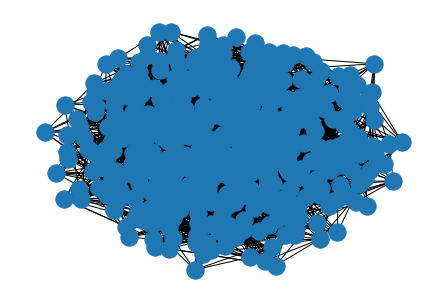

In [231]:
Gnx = nx.connected_watts_strogatz_graph(N, M, 0.5, tries=100)
print(nx.number_of_edges(Gnx))
nx.draw(Gnx)
Gnx_c = Gnx.copy()

In [232]:
G = nx.to_numpy_array(Gnx_c)
aux = np.random.rand(*G.shape)
W = (aux < 0.85)*(np.random.random(size=G.shape)/10) + (aux > 0.85)*(np.random.random(size=G.shape)/20 + 0.3 )
G = G*W

In [233]:
Gnx.nodes[0]['I'] = 0
Gnx_c.nodes[0]['I'] = 0

In [234]:
Gnx.degree[0]

11

Espalhamento da doença:

In [235]:
def SIR_simulation(Gnx, G):
  I_0 = [0]
  for day in range(1,T+1):
    I_1 = []
    if I_0:
      for node in I_0:
        for neighbor in Gnx.neighbors(node):
          if (Gnx.nodes.data('I')[neighbor] is None):
            U = np.random.random()
            if G[node, neighbor] > U:
              I_1.append(neighbor)
              Gnx.nodes[neighbor]['I'] = day
    I_0 = I_1
    print(I_0)
  return Gnx

In [236]:
Gnx = Gnx_c.copy()
G_SIR = SIR_simulation(Gnx, G)

[]
[]
[]
[]
[]
[]
[]


In [237]:
S = 0
for t in range(T+1):
  s = 0
  for node in G_SIR.nodes:
    if G_SIR.nodes.data('I')[node] == t:
      s += 1
  S += s
  print(t, ' :', s)
print(S)

0  : 1
1  : 0
2  : 0
3  : 0
4  : 0
5  : 0
6  : 0
7  : 0
1


Algoritmo

In [209]:
C = []
for v in G_SIR.nodes:
  if type(G_SIR.nodes.data('I')[v]) == int:
    #U = np.random.random()
    #if U < 0.1:
    C += [[v, G_SIR.nodes.data('I')[v]]]
C_ = pd.DataFrame(C)
C_ = C_.rename(columns={0: 'node', 1: 'time'})
C = C_.sample(frac = 0.9)
#C = C_[C_['time'] == 1]
#for t in range(2,T-1):
#  C = pd.concat([C, C_[C_['time'] == t].sample(frac=0.99)])
#C

In [210]:
len(C)

225

In [211]:
from decimal import *
getcontext().prec = 100

In [212]:
def estimator_P_C(C, num = 50):
  Q = 0
  n = 0
  k = 0
  Tree = Gnx_c.copy()
  while n < num:
    L = Decimal(1)
    for t in range(1,T+1):
      Inf = set()
      infec = [Decimal(1) for i in range(N)]
      n_infec = [Decimal(1) for i in range(N)]
      for v in search_nodes(Tree, {"==": [("I",), t-1]}):
        for u in Tree.neighbors(v):
          if u in C.node.values:
            if C[C['node'] == u].time.values[0] == t:
              infec[u] *= Decimal(str(1-G[v,u]))
              Tree.nodes[u]['I'] = t
              Inf = Inf.union({u})
            else:
              n_infec[u] *= Decimal(str(1-G[v,u]))
          else:
            U = np.random.random()
            if (Tree.nodes.data('I')[u] is None):
              if U <  G[v,u]:
                Tree.nodes[u]['I'] = t
      L *= reduce(lambda x,y:x*y, n_infec)
      for i in infec:
        if i != Decimal(1):
          L *= (Decimal(1)-i)
      fail = Inf != set(C[C['time'] == t].node)
      if fail:
        break
    k += 1
    if k > 300:
      print(k)
      return
    if not fail:
      n += 1
      Q += L
  Q = Q / Decimal(num)
  print(k)
  return Q

In [213]:
p1 = estimator_P_C(C, num = 200)
p1

KeyboardInterrupt: ignored

In [ ]:
d = pd.DataFrame({'node': [16], 'time': [2]})
p2 = estimator_P_C(pd.concat([C, d]),num = 200)
p2

In [ ]:
p2/p1